In [12]:
from datascience import *
import numpy as np
## Normal Distribution
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from IPython.display import Image
from IPython.core.display import HTML 

In [13]:
def distance(pt1, pt2):
    """The Euclidean distance between two arrays of numbers."""
    return np.sqrt(np.sum((pt1 - pt2)**2))

def distance_from_individual(attribute_table, i, p):
    """The Euclidean distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    return distance(np.array(attribute_table.row(i)), p)

def table_with_dists(training, p):
    """A copy of the training table with the Euclidean distance from each row to array p."""
    dists = make_array()
    attributes = training.drop('Class')
    for i in np.arange(training.num_rows):
        dists = np.append(dists, distance_from_individual(attributes, i , p))
    return training.with_column('Distance', dists)

def closest(training, p, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_dists(training, p)
    sorted_by_dist = with_dists.sort('Distance')
    topk = sorted_by_dist.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [14]:
# helper methods:

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, x, y):
    """The slope of the regression line (original units)"""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)"""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(t, x, y):
    """Return the predicted y-value for each x-value"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b


## Least Squares

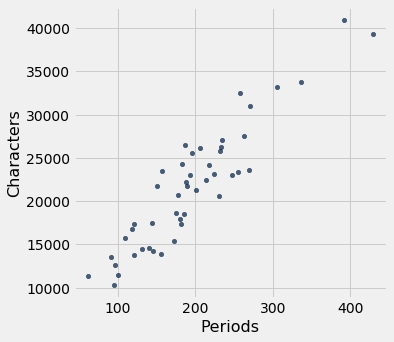

In [15]:
#little_women = Table.read_table('http://inferentialthinking.com/notebooks/little_women.csv')
little_women = Table.read_table('little_women.csv')

little_women = little_women.move_to_start('Periods')
little_women.scatter('Periods', 'Characters')

In [16]:
# What correlation do you expect?

correlation(little_women, 'Periods', 'Characters')

0.92295768958548163

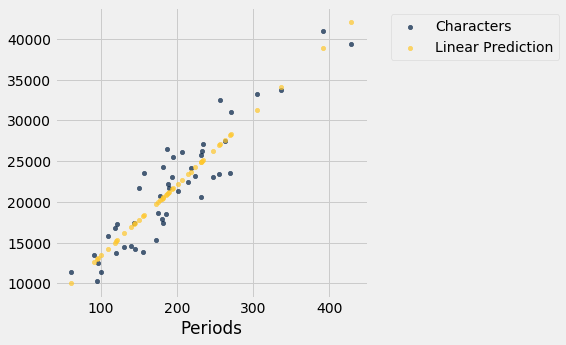

In [17]:
# helper method

def fit(t, x, y):
    """Return the predicted y-value for each x-value"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

fitted = fit(little_women, 'Periods', 'Characters')  # array of predictions predictions

lw_with_predictions = little_women.with_column('Linear Prediction', fitted) #table
lw_with_predictions.scatter('Periods')  #plot

In [18]:
# errors: 

actual = lw_with_predictions.column('Characters')
predicted = lw_with_predictions.column('Linear Prediction')
errors = actual - predicted

lw_with_predictions.with_column("Error", errors)

Periods,Characters,Linear Prediction,Error
189,21759,21183.6,575.403
188,22148,21096.6,1051.38
231,20558,24836.7,-4278.67
195,25526,21705.5,3820.54
255,23395,26924.1,-3529.13
140,14622,16921.7,-2299.68
131,14431,16138.9,-1707.88
214,22476,23358,-882.043
337,33767,34056.3,-289.317
185,18508,20835.7,-2327.69


In [19]:
#function to draw errors

sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    print('Slope of Regression Line:    ', np.round(slope), 'characters per period')
    print('Intercept of Regression Line:', np.round(intercept), 'characters')
    little_women.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plt.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plt.plot([x, x], [y, slope * x + intercept], color='r', lw=2)


Slope of Regression Line:     87.0 characters per period
Intercept of Regression Line: 4745.0 characters


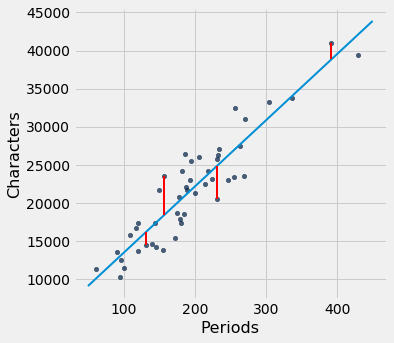

In [20]:
#slope, intercept and errors:

lw_reg_slope = slope(little_women, 'Periods', 'Characters')
lw_reg_intercept = intercept(little_women, 'Periods', 'Characters')
lw_errors(lw_reg_slope, lw_reg_intercept)

Slope of Regression Line:     50 characters per period
Intercept of Regression Line: 10000 characters


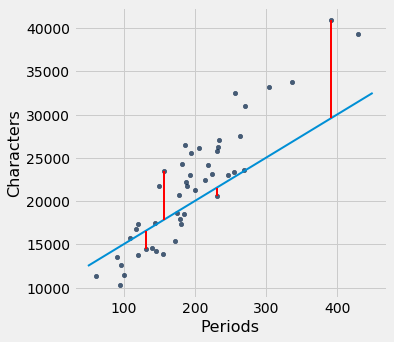

In [21]:
# takes any slope, any intercept and redraws the line and errors from the same 4 points

lw_errors(50, 10000)

Slope of Regression Line:     -100 characters per period
Intercept of Regression Line: 50000 characters


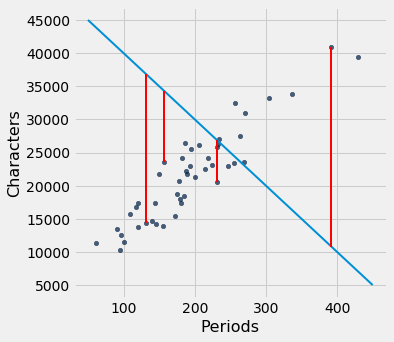

In [22]:
lw_errors(-100, 50000)

In [23]:
# Which lines are better? The ones with small errors
# Goal: Find the line that minimizes the error

# What exactly will we minimize?

In [24]:
def lw_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    print("Root mean squared error:", mse ** 0.5)

Slope of Regression Line:     50 characters per period
Intercept of Regression Line: 10000 characters
Root mean squared error: 4322.16783177


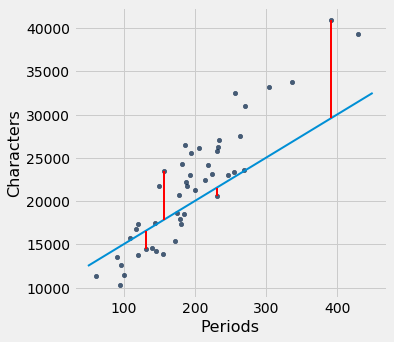

In [25]:
# is the error small or large?
lw_rmse(50, 10000)

Slope of Regression Line:     -100 characters per period
Intercept of Regression Line: 50000 characters
Root mean squared error: 16710.1198374


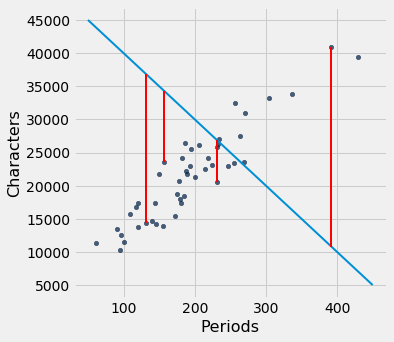

In [26]:
# for comparison

lw_rmse(-100, 50000)

Slope of Regression Line:     90 characters per period
Intercept of Regression Line: 4000 characters
Root mean squared error: 2715.53910638


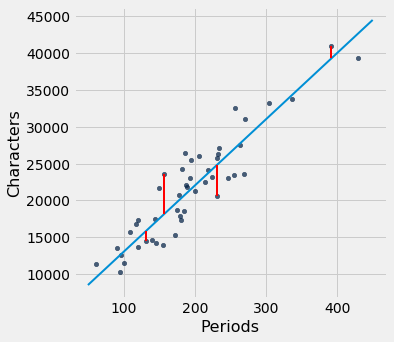

In [27]:
# close to the regression line
lw_rmse(90, 4000)

Slope of Regression Line:     87.0 characters per period
Intercept of Regression Line: 4745.0 characters
Root mean squared error: 2701.69078531


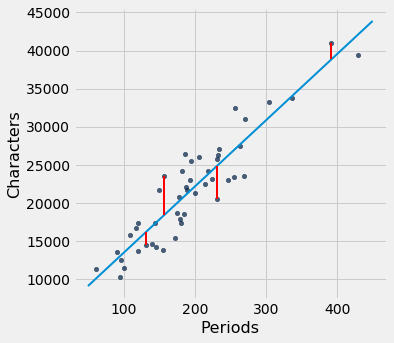

In [28]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

In [29]:
# drop the square root

def lw_mse(any_slope, any_intercept):
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [30]:
# What is it going to return?

minimize(lw_mse)

array([   86.97784117,  4744.78484535])

In [31]:
lw_reg_slope, lw_reg_intercept

(86.977841258298213, 4744.7847965749279)

In [32]:
#(back to slides for discussion questions)

## Residuals

In [35]:
galton = Table.read_table('galton.csv')



heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )


In [36]:
# function to calculate residuals

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)


In [37]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


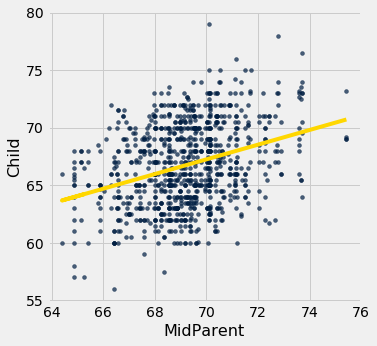

In [38]:
def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plt.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plt.xlabel(x)
    plt.ylabel(y)
    
scatter_fit(heights, 'MidParent', 'Child')    

In [39]:
# A residual plot: plotting the residuals against the predictor variable (midparent height)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plt.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plt.title('Residual Plot')


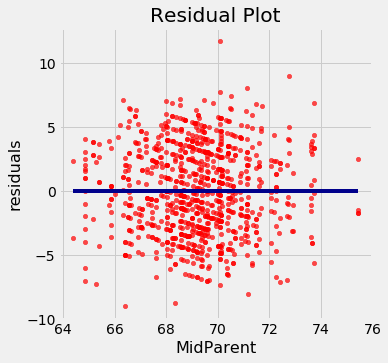

In [40]:
residual_plot(heights, 'MidParent', 'Child')


In [41]:
# (back to slides)

## What issues can residual plots detect?

In [42]:
# ages are estimates
dugong = Table.read_table('http://www.statsci.org/data/oz/dugongs.txt')
dugong = dugong.move_to_start('Length')
dugong

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5
2.27,4
2.15,5
2.26,5
2.35,7
2.47,8


In [43]:
# Length is easy to measure. You know the length, predict the age

correlation(dugong, 'Length', 'Age')

0.82964745549057139

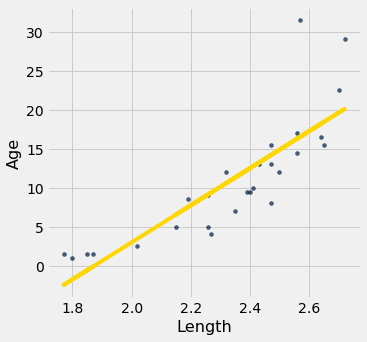

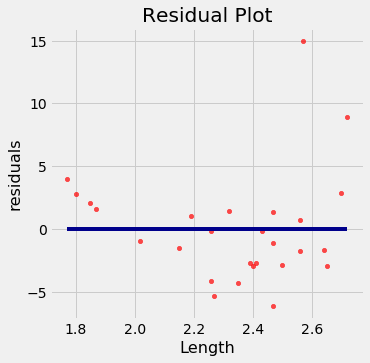

In [44]:
#helper method

def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)


regression_diagnostic_plots(dugong, 'Length', 'Age')

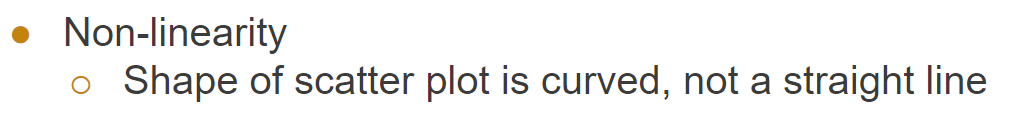

In [45]:
Image("17_1.png", width=800, height=400)

In [46]:
hybrid = Table.read_table('hybrid.csv')
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


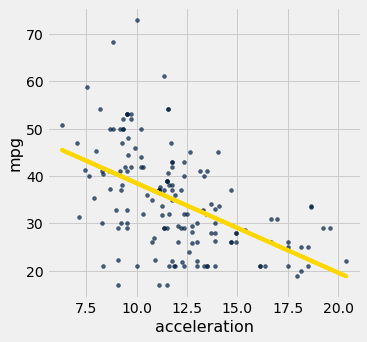

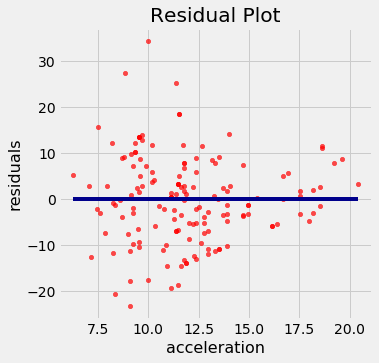

In [47]:
regression_diagnostic_plots(hybrid, 'acceleration', 'mpg')


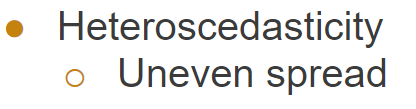

In [48]:
Image("17_2.png", width=400, height=200)

In [49]:
# What does it mean? Predictions are not equally accurate for different values of acceleration 

-2.7196898076470642e-16

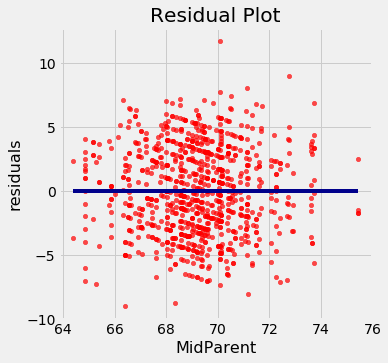

In [50]:
#Residual Plots are Flat Overall

residual_plot(heights, 'MidParent', 'Child')
correlation(heights, 'MidParent', 'Residual')

In [51]:
# The Average of the Residuals

round(np.mean(heights.column('Residual')), 10)

0.0

## Classification

In [52]:
# Class 1: patient has Chronic kidney disease
# Class 0: patient does not have Chronic kidney disease

ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(50)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


In [53]:
# New patient comes along, we give them a blood test. How can we tell based on this data whether they have CKD or not?

In [54]:
# Simplification: use only Hemoglobin, Glucose and White Blood Cell Count
# Scale to use?

In [55]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


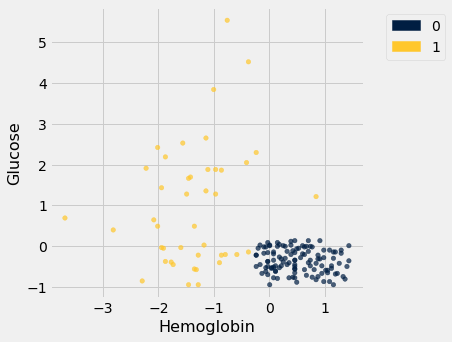

In [56]:
# Visualize:

ckd.scatter('Hemoglobin', 'Glucose', colors='Class')

#regression: care about shape
#classification" care about separation
#is there a separation?

In [57]:
# Discussion question

Image("img_CKD.png", width=800, height=300)

In [58]:
# you can ignore that for now. gives wrong line

def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)


def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))


def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

    
def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(0)
    y_closest = t.row(0).item(1)
    ckd.scatter('Hemoglobin', 'Glucose', colors='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

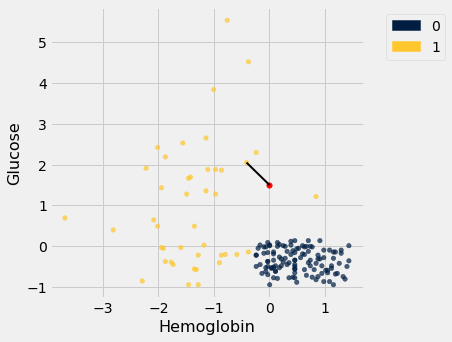

In [59]:
alice =  make_array(0, 1.5) #try with other values
show_closest(alice)

In [60]:
# HIDDEN

x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

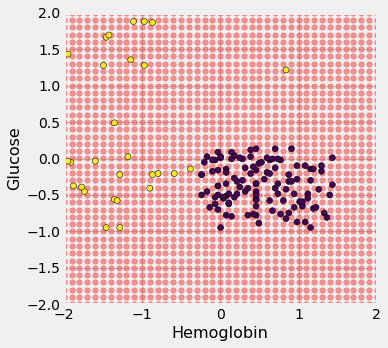

In [61]:
test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Class'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

In [62]:
# By eye, which red points will you be able to classify easily and where will you have trouble?

In [63]:
# HIDDEN
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

c = classify_grid(ckd.drop('White Blood Cell Count'), test_grid, 1)

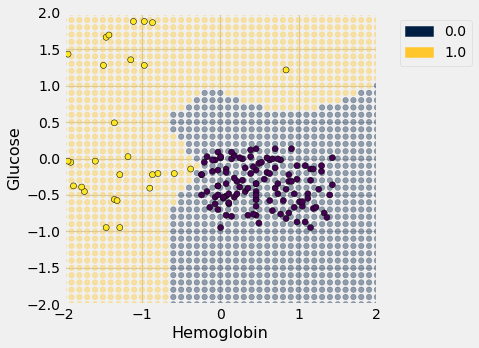

In [64]:
test_grid = test_grid.with_column('Class', c)#.join('Class', color_table)
test_grid.scatter('Hemoglobin', 'Glucose', colors='Class', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Class'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

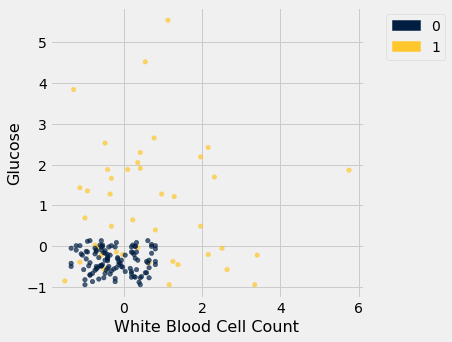

In [65]:
# you have decision regions

# Now let's try another pair of attributes
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Class')


In [66]:
#How to classify a point in blue cloud that happens to be right next to a yellow point?

#(back to slides)

## Accuracy of Classifier

In [67]:
# Using 1-Neighbor Classifier how do you know that your prediction is good? (for a new person)

In [68]:
# creating training and testing data sets

shuffled_ckd = ckd.sample(with_replacement=False)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

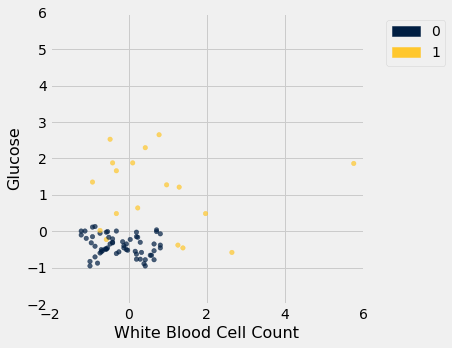

In [69]:
training.scatter('White Blood Cell Count', 'Glucose', colors='Class')
plt.xlim(-2, 6)
plt.ylim(-2, 6);

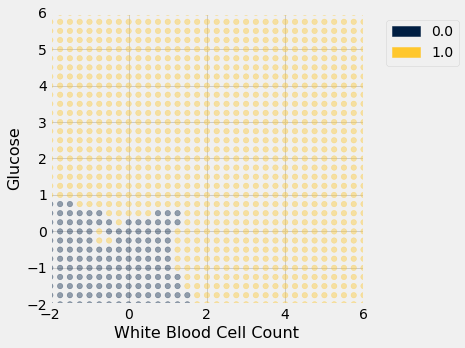

In [70]:
# HIDDEN

x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Glucose', x_array,
    'White Blood Cell Count', y_array
)

c = classify_grid(training.drop('Hemoglobin'), test_grid, 1)

test_grid = test_grid.with_column('Class', c)#.join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Class', alpha=0.4, s=30)

plt.xlim(-2, 6)
plt.ylim(-2, 6);

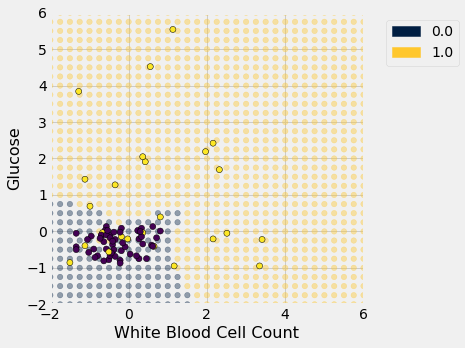

In [71]:
# place test data

# HIDDEN

test_grid = test_grid.with_column('Class', c)#.join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Class', alpha=0.4, s=30)

plt.scatter(testing.column('White Blood Cell Count'), testing.column('Glucose'), c=testing.column('Class'), edgecolor='k')

plt.xlim(-2, 6)
plt.ylim(-2, 6);
